In [33]:
%matplotlib inline
from __future__ import print_function, division

import sys, os
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from peerless.settings import PEERLESS_DATA_DIR
EB_DIR = os.path.join(PEERLESS_DATA_DIR, 'population_sims', 'ebs')
BEB_DIR = os.path.join(PEERLESS_DATA_DIR, 'population_sims', 'bebs')

# Start by reading in all the simulated catalogs

ebs = [pd.read_hdf(os.path.join(EB_DIR, '{}.h5'.format(i)), 'df') for i in range(100)]
bebs = [pd.read_hdf(os.path.join(BEB_DIR, '{}.h5'.format(i)), 'df') for i in range(100)]

Look at the distribution of the number of simulated EBs with $P > 5$, and compare to the expected number from the Kepler EB catalog.

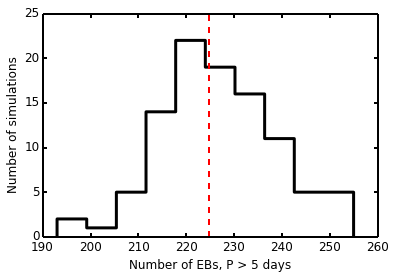

In [34]:
from peerless.catalogs import KICatalog, EBCatalog
targets = pd.read_hdf('targets.h5', 'df')

n_expected = len(EBCatalog().df.query('period > 5')) * len(targets)/len(KICatalog().df)

n_ebs = [len(e.query('n_pri > 2 or n_sec > 2 or (n_pri > 0 and n_sec > 0)')) for e in ebs]

fig, ax = plt.subplots(1,1)
ax.hist(n_ebs, histtype='step', lw=3, color='k')
ax.axvline(n_expected, color='r', ls='--')
ax.set_ylabel('Number of simulations')
ax.set_xlabel('Number of EBs, P > 5 days');

So this says that our simulations are very consistent with what Kepler has catalogued.

In [35]:
q = '((n_pri + n_sec) < 3) and (n_pri==0 or n_sec==0)'
ebs_all = pd.concat(ebs).query(q)
bebs_all = pd.concat(bebs).query(q)
n_ebs = np.array([len(e.query(q)) for e in ebs])
n_bebs = np.array([len(b.query(q)) for b in bebs])
print('Average number of single/double-eclipsing EBs: {0:.2f} +/- {1:.2f}'.format(n_ebs.mean(), n_ebs.std()))
print('Average number of single/double-eclipsing BEBs: {0:.2f} +/- {1:.2f}'.format(n_bebs.mean(), n_bebs.std()))

Average number of single/double-eclipsing EBs: 9.32 +/- 3.17
Average number of single/double-eclipsing BEBs: 3.33 +/- 1.81


Now, let's look at the depth/duration distribution of these signals.

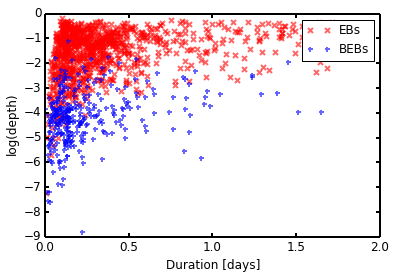

In [36]:
def plot_depthdur(df, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1)
      
    pri = df.n_pri > 0
    sec = df.n_sec > 0

    depth = pri*df.d_pri + sec*df.d_sec
    duration = pri*df.T14_pri + sec*df.T14_sec
    ax.plot(duration, np.log10(depth), **kwargs)
    ax.set_xlabel('Duration [days]')
    ax.set_ylabel('log(depth)')

fig, ax = plt.subplots(1,1)
plot_style = dict(ls='none', ms=5, alpha=0.6)
plot_depthdur(ebs_all, ax=ax, color='r', marker='x', label='EBs', **plot_style)
plot_depthdur(bebs_all, ax=ax, color='b', marker='+', label='BEBs', **plot_style)
ax.set_xlim(xmax=2)
ax.legend();

Maybe it's more useful to use KDEs, especially to also visualize candidates.

In [37]:
from scipy.stats import gaussian_kde

def get_kde(df):
    
    pri = df.n_pri > 0
    sec = df.n_sec > 0

    depth = pri*df.d_pri + sec*df.d_sec
    duration = pri*df.T14_pri + sec*df.T14_sec            
        
    ok = ~np.isinf(np.log10(depth))
    return gaussian_kde(np.array([duration[ok], np.log10(depth)[ok]]))

eb_kde = get_kde(ebs_all)
beb_kde = get_kde(bebs_all)

In [38]:
candidates = pd.read_csv('../candidates.csv').query('accept_bic and accept_time and num_peaks <= 2')
candidates[['depth','transit_duration']].head()

,depth,transit_duration
0,0.000626,0.444890
1,0.046311,0.378785
2,0.002579,0.295183
3,0.003340,0.393807
5,0.002230,0.627717


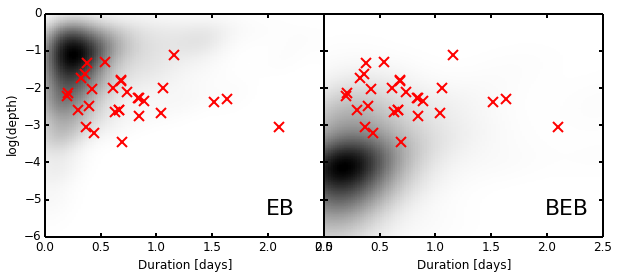

In [39]:
def plot_kde(kde, ax=None, dur_range=(0,2.5), depth_range=(-6,0), 
            cands=candidates, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    dur_grid = np.arange(dur_range[0], dur_range[1], 0.02)
    depth_grid = np.arange(depth_range[0], depth_range[1], 0.02)
    xx, yy = np.meshgrid(dur_grid, depth_grid)
    f = kde(np.vstack([xx.ravel(),yy.ravel()])).reshape(xx.shape)
    ax.imshow(f, origin='lower', extent=[dur_range[0], dur_range[1],
                                         depth_range[0], depth_range[1]], 
               aspect='auto', cmap='binary', **kwargs)
    ax.set_xlabel('Duration [days]')
    ax.set_ylabel('log(depth)')
    
    if cands is not None:
        ax.plot(cands.transit_duration, np.log10(cands.depth), 'rx', ms=10)
    
fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
plot_kde(eb_kde, ax=axes[0])
plot_kde(beb_kde, ax=axes[1])
axes[1].set_ylabel('')
plt.subplots_adjust(wspace=0)
for ax,title in zip(axes, ['EB','BEB']):
    ax.annotate(title, xy=(0.8,0.1), xycoords='axes fraction', fontsize=22)